## Simple AutoEncoder

In [21]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import contingency_matrix
import os
import decimal
from math import log
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [22]:
df = pd.read_csv('data.csv')
df.shape

(24998, 30)

In [23]:
# df = dataset.sample(60000)
X = df.drop('xAttack', axis = 1)
Y = df['xAttack']

In [24]:
trainYnew=[]
for i in Y:
    if i=='normal':
        trainYnew.append(0)
    elif i=='dos':
        trainYnew.append(1)
    elif i=='r2l':
        trainYnew.append(2)
    elif i=='probe':
        trainYnew.append(3)
    elif i=='u2r':
        trainYnew.append(4)

In [25]:
#Standardization of data
X = (X - np.mean(X))/np.std(X)

In [26]:
def sigmoid(s):
    return 1/(1 + np.exp((-s)))

def sigmoid_derv(s):
    return s * (1 - s)

# No activation function
def linear(x):
    return x

# No activation function
def linear_derv(x):
    linear_grad = np.ones(x.shape)
    return linear_grad


def tanh(s):
    return np.tanh(s)

def tanh_derv(s):
    return 1.0 - np.tanh(s)**2

def ReLU(x):
    return x * (x > 0)

def ReLU_derv(x):
    return 1. * (x > 0)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = np.square(pred - real)
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

In [27]:
class MyNN_sigmoid(object):
    def __init__(self, x, y,n):
        self.x = x
        self.y = y
        self.neurons = 14
        self.lr = 0.000001
        self.hiddenLayers = 1
        self.ip_dim = x.shape[1]
        self.op_dim = y.shape[1]
        self.w = {}
        self.b = {}
        self.z = {}
        self.a = {}
        self.da = {}
        self.dz = {}
        self.error=[]
        
    def initialization(self):
        self.w[1] = np.random.randn(self.ip_dim, self.neurons)
        for i in np.arange(2,self.hiddenLayers+1):
            self.w[i] = np.random.randn(self.neurons, self.neurons)
        self.w[self.hiddenLayers+1] = np.random.randn(self.neurons, self.op_dim)

    def feedforward(self):
        self.z[1] = np.dot(self.x, self.w[1]) 
        self.a[1] = linear(self.z[1])
        for i in np.arange(2,self.hiddenLayers+2):
            self.z[i] = np.dot(self.a[i-1], self.w[i])
            self.a[i] = linear(self.z[i])
        
    def backprop(self):
        self.error.append(np.sum(cross_entropy(self.a[self.hiddenLayers+1], self.y)))
        self.da[self.hiddenLayers+1] = cross_entropy(self.a[self.hiddenLayers+1], self.y)
        for i in range(self.hiddenLayers,0,-1):
            self.dz[i] = np.dot(self.da[i+1], self.w[i+1].T)
            self.da[i] = self.dz[i] * linear_derv(self.a[i])
        self.w[self.hiddenLayers+1] -= self.lr * np.dot(self.a[self.hiddenLayers].T, self.da[self.hiddenLayers+1])
        for i in range(self.hiddenLayers,1,-1):
            self.w[i] -= self.lr * np.dot(self.a[i-1].T, self.da[i])
        self.w[1] -= self.lr * np.dot(self.x.T, self.da[1])

    def predict(self, data):
        return np.dot(data,self.w[1])

In [28]:
model = MyNN_sigmoid(X,X,1)
model.initialization()    
epochs = 10
for x in range(epochs):
    model.feedforward()
    model.backprop()

In [29]:
abc=model.predict(X)
abc.shape
abc

array([[ -1.78363132,   1.73838836,  -7.03550025, ...,   2.54403871,
          2.60244564,   1.03430237],
       [  1.61582052,  -5.57565095,  11.64375096, ...,   6.05981948,
         -5.1632739 ,  -8.65782956],
       [ -1.37776933,   2.1229658 ,  -7.09963952, ...,   2.60061106,
          3.10272074,   1.74853676],
       ...,
       [-16.40737336,  62.06149248, -57.88322505, ..., -10.4228624 ,
         32.22671027, -47.34596188],
       [-10.30164254,   5.78878593, -17.86201912, ...,  -0.16951373,
         -2.86716219,   3.40797242],
       [  1.4251849 ,  -0.95140495,   9.70910649, ...,  -3.64459616,
         -2.26600518,   3.03770819]])

In [30]:
# Number of clusters
k = 5
# Number of training data
n = abc.shape[0]
# Number of features in the data
c = abc.shape[1]

# Generate random centers, here we use sigma an# data.shaped mean to ensure it represent the whole data
mean = np.mean(abc, axis = 0)

std = np.std(abc, axis = 0)
# print np.random.randn(k,c)

centers = np.random.randn(k,c)
# print centers
centers_old = np.zeros(centers.shape) # to store old centers
centers_new = copy.deepcopy(centers) # Store new centers
clusters = np.zeros(n)
distances = np.zeros((n,k))

error = np.linalg.norm(centers_new - centers_old)
# When, after an update, the estimate of that center stays the same, exit loop
while error != 0:
    # Measure the distance to every center
    for i in range(k):
        distances[:,i] = np.linalg.norm(abc - centers[i], axis=1)
    # Assign all training data to closest center
    clusters = np.argmin(distances, axis = 1)
    
    centers_old = copy.deepcopy(centers_new)
    # Calculate mean for every cluster and update the center
    for i in range(k):
        centers_new[i] = np.mean(abc[clusters == i], axis=0)
    error = np.linalg.norm(centers_new - centers_old)

clusters

array([0, 1, 4, ..., 1, 4, 1])

In [31]:
contin=contingency_matrix(clusters,Y)
ans=0
for i in contin:
    ans=ans+max(i)
purity=ans/float(len(X))
print("Purity of Entire dataset-",purity)
j=0
lkgraph=[]
for i in contin:
    purity=max(i)/sum(i)
    print("Purity of cluster {} is {} ".format(j,purity))
    j+=1
    lkgraph.append(purity)

Purity of Entire dataset- 0.8030242419393552
Purity of cluster 0 is 0.5676901605024425 
Purity of cluster 1 is 0.8000250438266967 
Purity of cluster 2 is 0.7041009463722397 
Purity of cluster 3 is 0.9206576125804146 
Purity of cluster 4 is 0.7712982961363091 


In [35]:
#GMM clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5).fit(abc)
labels = gmm.predict(abc)
contin2=contingency_matrix(labels,trainYnew)
ans=0
for i in contin2:
    ans=ans+max(i)
purity=ans/float(len(abc))
print("Purity of Entire dataset-",purity)
j=0
lggraph=[]
for i in contin2:
    purity=max(i)/sum(i)
    print("Purity of cluster {} is {} ".format(j,purity))
    j+=1
    lggraph.append(purity)

Purity of Entire dataset- 0.8329066325306025
Purity of cluster 0 is 1.0 
Purity of cluster 1 is 0.5044322498944702 
Purity of cluster 2 is 0.9371823151433778 
Purity of cluster 3 is 1.0 
Purity of cluster 4 is 1.0 


In [38]:
#heirarchical clustering
abc_new=abc[0:10000]
# print abc.shape
trainYnew_mem = np.array(trainYnew)
trainYnew_mem = trainYnew_mem[0:10000]
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
y_pred=cluster.fit_predict(abc_new)
contin=contingency_matrix(y_pred,trainYnew_mem)
ans=0
for i in contin:
    ans=ans+max(i)
purity=ans/float(len(abc_new))
print("Purity of Entire datasets:-",purity)
j=0
lhgraph=[]
for i in contin:
    purity=max(i)/sum(i)
    print("Purity of cluster {} is {} ".format(j,purity))
    j+=1
    lhgraph.append(purity)

Purity of Entire datasets:- 0.5343
Purity of cluster 0 is 0.5340272217774219 
Purity of cluster 1 is 0.75 
Purity of cluster 2 is 1.0 
Purity of cluster 3 is 1.0 
Purity of cluster 4 is 1.0 


# Part 5

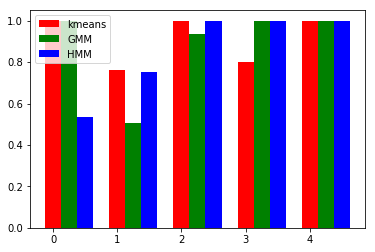

In [37]:
barWidth = 0.25
r1 = np.arange(len(lkgraph))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, lkgraph,color='red', width=barWidth,label='kmeans')
plt.bar(r2, lggraph, color='green', width=barWidth,label='GMM')
plt.bar(r3, lhgraph, color='blue', width=barWidth,label='HMM')
plt.legend()